In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 jupyter jupyter 66 Jan 25 21:43 kaggle.json


In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/covid-world-vaccination-progress                COVID-19 World Vaccination Progress                  33KB  2021-01-26 09:20:28           2272        153  1.0              
google/android-smartphones-high-accuracy-datasets      Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11            659         83  0.875            
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05            398         47  1.0              
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data                  

In [19]:
!kaggle competitions download -c ga-customer-revenue-prediction

ga-customer-revenue-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
import zipfile
with zipfile.ZipFile('/home/jupyter/ga-customer-revenue-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = None

In [246]:
!pip install lightgbm

import lightgbm as lgb

In [5]:
data1 = pd.read_csv("/home/jupyter/train_v2.csv", nrows=2)
data1

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307


In [6]:
usecols = [c for c in data1.columns if c not in ['customDimensions', 'hits', 'socialEngagementType']]
usecols

['channelGrouping',
 'date',
 'device',
 'fullVisitorId',
 'geoNetwork',
 'totals',
 'trafficSource',
 'visitId',
 'visitNumber',
 'visitStartTime']

In [7]:
dtypes = {
    'channelGrouping': 'object',
    'date': 'object',
    'fullVisitorId': 'object',
    'visitId': 'int64',
    'visitNumber': 'int64',
    'visitStartTime': 'int64'
}

def load_df(csv_path=None, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,dtype=dtypes,nrows=nrows,converters={column: json.loads for column in JSON_COLUMNS},usecols=usecols)
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [8]:
%%time
train = load_df('/home/jupyter/train_v2.csv')

Loaded train_v2.csv. Shape: (1708337, 57)
CPU times: user 4min 56s, sys: 1min 4s, total: 6min
Wall time: 6min


In [9]:
%%time
test = load_df('/home/jupyter/test_v2.csv')

Loaded test_v2.csv. Shape: (401589, 56)
CPU times: user 1min 21s, sys: 4.82 s, total: 1min 26s
Wall time: 1min 27s


In [10]:
train

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,1,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,Windows,not availabl

In [11]:
test

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.timeOnSite,totals.sessionQualityDim,totals.newVisits,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.bounces,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,20180511,7460955084541987166,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,Delhi,(not set),(not set),not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,973,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,20180511,460252456180441002,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Francisco,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,49,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20180511,3461808543879602873,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,3,24,1,NaN,NaN,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,20180511,975129477712150630,1526107551,4,1526107551,Chrome,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not availa

In [12]:
train.isnull().sum()

channelGrouping                                            0
date                                                       0
fullVisitorId                                              0
visitId                                                    0
visitNumber                                                0
visitStartTime                                             0
device.browser                                             0
device.browserVersion                                      0
device.browserSize                                         0
device.operatingSystem                                     0
device.operatingSystemVersion                              0
device.isMobile                                            0
device.mobileDeviceBranding                                0
device.mobileDeviceModel                                   0
device.mobileInputSelector                                 0
device.mobileDeviceInfo                                    0
device.mobileDeviceMarke

In [13]:
test.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserVersion                                     0
device.browserSize                                        0
device.operatingSystem                                    0
device.operatingSystemVersion                             0
device.isMobile                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceModel                                  0
device.mobileInputSelector                                0
device.mobileDeviceInfo                                   0
device.mobileDeviceMarketingName        

In [14]:
train.nunique(dropna=False)

channelGrouping                                            8
date                                                     638
fullVisitorId                                        1323730
visitId                                              1665802
visitNumber                                              457
visitStartTime                                       1667423
device.browser                                           129
device.browserVersion                                      1
device.browserSize                                         1
device.operatingSystem                                    24
device.operatingSystemVersion                              1
device.isMobile                                            2
device.mobileDeviceBranding                                1
device.mobileDeviceModel                                   1
device.mobileInputSelector                                 1
device.mobileDeviceInfo                                    1
device.mobileDeviceMarke

In [15]:
test.nunique(dropna=False)

channelGrouping                                           8
date                                                    168
fullVisitorId                                        296530
visitId                                              393181
visitNumber                                             386
visitStartTime                                       393643
device.browser                                           62
device.browserVersion                                     1
device.browserSize                                        1
device.operatingSystem                                   22
device.operatingSystemVersion                             1
device.isMobile                                           2
device.mobileDeviceBranding                               1
device.mobileDeviceModel                                  1
device.mobileInputSelector                                1
device.mobileDeviceInfo                                   1
device.mobileDeviceMarketingName        

In [16]:
cnst_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1]
cnst_cols

['device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [17]:
cnst_cols1 = [c for c in test.columns if test[c].nunique(dropna=False)==1]
cnst_cols1

['device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [18]:
cnst_cols==cnst_cols1

True

In [33]:
# drop constant columns (columns with only 1 unique value)
train = train.drop(cnst_cols, axis=1)
test = test.drop(cnst_cols, axis=1)

KeyError: "['device.browserVersion' 'device.browserSize'\n 'device.operatingSystemVersion' 'device.mobileDeviceBranding'\n 'device.mobileDeviceModel' 'device.mobileInputSelector'\n 'device.mobileDeviceInfo' 'device.mobileDeviceMarketingName'\n 'device.flashVersion' 'device.language' 'device.screenColors'\n 'device.screenResolution' 'geoNetwork.cityId' 'geoNetwork.latitude'\n 'geoNetwork.longitude' 'geoNetwork.networkLocation' 'totals.visits'\n 'trafficSource.adwordsClickInfo.criteriaParameters'] not found in axis"

In [34]:
test.nunique(dropna=False)

channelGrouping                                      8
date                                               168
fullVisitorId                                   296530
visitId                                         393181
visitNumber                                        386
visitStartTime                                  393643
device.browser                                      62
device.operatingSystem                              22
device.isMobile                                      2
device.deviceCategory                                3
geoNetwork.continent                                 6
geoNetwork.subContinent                             23
geoNetwork.country                                 208
geoNetwork.region                                  268
geoNetwork.metro                                    81
geoNetwork.city                                    502
geoNetwork.networkDomain                         15933
totals.hits                                        208
totals.pag

In [35]:
train.nunique(dropna=False)

channelGrouping                                       8
date                                                638
fullVisitorId                                   1323730
visitId                                         1665802
visitNumber                                         457
visitStartTime                                  1667423
device.browser                                      129
device.operatingSystem                               24
device.isMobile                                       2
device.deviceCategory                                 3
geoNetwork.continent                                  6
geoNetwork.subContinent                              23
geoNetwork.country                                  228
geoNetwork.region                                   482
geoNetwork.metro                                    122
geoNetwork.city                                     955
geoNetwork.networkDomain                          41981
totals.hits                                     

In [22]:
#for c in train.loc[:, 'device.browser':'geoNetwork.networkDomain'].columns:
#    print(train[c].unique())

['Firefox' 'Chrome' 'Safari' 'UC Browser' 'Internet Explorer' 'Edge'
 'Samsung Internet' 'Android Webview' 'Safari (in-app)' 'Opera Mini'
 'Opera' 'YaBrowser' 'Amazon Silk' 'Mozilla Compatible Agent' 'Puffin'
 'Maxthon' 'BlackBerry' 'ADM' 'Coc Coc' 'MRCHROME' 'Android Browser'
 'Playstation Vita Browser' 'Nintendo Browser' 'Nokia Browser' 'SeaMonkey'
 'Lunascape' 'IE with Chrome Frame' 'ThumbSniper' 'LYF_LS_4002_12'
 'DESKTOP' 'Mozilla' 'Browser' 'osee2unifiedRelease' 'Seznam' '(not set)'
 ';__CT_JOB_ID__:65da7e5f-0f05-4b5d-8d31-1f4d470a2b82;' 'Apple-iPhone7C2'
 ';__CT_JOB_ID__:a80e8e16-6e98-455b-885a-a4dd40f3d344;'
 ';__CT_JOB_ID__:89e59554-ad41-4e94-957b-f12bd012530c;'
 'DDG-Android-3.1.1' 'NokiaE52-1' 'Iron'
 '[Use default User-agent string] LIVRENPOCHE' 'Konqueror'
 ';__CT_JOB_ID__:7e575295-571e-4e82-9254-7f2c8bbb9183;' 'LYF_LS_4002_11'
 'M5' 'Android Runtime' 'Changa 99695759' 'YE' 'no-ua' '+Simple Browser'
 'MQQBrowser' 'Nichrome' 'tfowdqmibyshaklxuregpcnzvj' 'Autn-WKOOP'
 'HTC80

In [23]:
#train['trafficSource.keyword'].value_counts().reset_index().head(20)

,index,trafficSource.keyword
0,(not provided),568933
1,(User vertical targeting),25918
2,(automatic matching),18464
3,6qEhsCssdK0z36ri,10870
4,(Remarketing/Content targeting),5826
5,1hZbAqLCbjwfgOH7,2990
6,google merchandise store,2612
7,Google Merchandise,1879
8,1X4Me6ZKNV0zg-jV,1277
9,google store,1148


In [24]:
# convert informal na values such as 'not available in demo dataset' to 'NA' 
informal_na = {
    'device.browser': '(not set)',
    'device.operatingSystem': '(not set)',
    'geoNetwork.continent': '(not set)',
    'geoNetwork.subContinent': '(not set)',
    'geoNetwork.country': '(not set)',
    'geoNetwork.region': ['(not set)', 'not available in demo dataset'],
    'geoNetwork.metro': ['(not set)', 'not available in demo dataset'],
    'geoNetwork.city': ['(not set)', 'not available in demo dataset'],
    'geoNetwork.networkDomain': ['(not set)', 'unknown.unknown'],
    'trafficSource.campaign': '(not set)',
    'trafficSource.source': '(not set)',
    'trafficSource.medium': ['(none)', '(not set)'],
    'trafficSource.keyword': ['(not provided)', '(not set)'],
    'trafficSource.adContent': '(not set)',
    'trafficSource.referralPath': '(not set)'
    
}

train = train.replace(informal_na, 'NA')
test = test.replace(informal_na, 'NA')

In [36]:
train.dtypes

channelGrouping                                 object
date                                            object
fullVisitorId                                   object
visitId                                          int64
visitNumber                                      int64
visitStartTime                                   int64
device.browser                                  object
device.operatingSystem                          object
device.isMobile                                   bool
device.deviceCategory                           object
geoNetwork.continent                            object
geoNetwork.subContinent                         object
geoNetwork.country                              object
geoNetwork.region                               object
geoNetwork.metro                                object
geoNetwork.city                                 object
geoNetwork.networkDomain                        object
totals.hits                                     object
totals.pag

In [37]:
train

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,NA,NA,NA,NA,1,1,1,1,1,NaN,NaN,NaN,NaN,NA,google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,NA,2,2,NaN,NaN,2,28,NaN,NaN,NaN,NA,sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,NA,NA,NA,windjammercable.net,2,2,NaN,1,1,38,NaN,NaN,NaN,NA,(direct),NA,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,NA,NA,NA,NA,2,2,NaN,1,1,1,NaN,NaN,NaN,NA,google,organic,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,NA,NA,NA,prod-infinitum.com.mx,2,2,NaN,1,1,52,NaN,NaN,NaN,NA,google,organic,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,20170104,5123779100307500332,1483554750,1,1483554750,Chrome,Windows,False,desktop,Americas,Caribbean,Puerto Rico,NA,NA,NA,prtc.net,17,15,NaN,1,NaN,626,NaN,NaN,NaN,NA,youtube.com,referral,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708333,Social,20170104,7231728964973959842,1483543798,1,1483543798,Chrome,Android,True,mobile,Asia,Southern Asia,Sri Lanka,NA,NA,NA,NA,18,13,NaN,1,NaN,258,NaN,NaN,NaN,NA,youtube.com,referral,NaN,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708334,Social,20170104,5744576632396406899,1483526434,1,1483526434,Android Webview,Android,True,mobile,Asia,Eastern Asia,South Korea,Seoul,NA,Seoul,NA,24,21,NaN,1,NaN,991,NaN,NaN,NaN,NA,youtube.com,referral,NaN,/yt/about/ko/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708335,Social,20170104,2709355455991750775,1483592857,1,1483592864,Chrome,Windows,False,desktop,Asia,Southeast Asia,Indonesia,NA,NA,NA,NA,24,22,NaN,1,NaN,1274,NaN,NaN,NaN,NA,facebook.com,referral,NaN,/l.php,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# delete column in train data but not in test data

print(len(train.columns), len(test.columns))
print(set(train.columns).difference(set(test.columns)))

38 38
set()


In [30]:
train.drop('trafficSource.campaignCode', axis=1, inplace=True)

In [39]:
set(test.columns) == set(train.columns)

True

In [40]:
to_num = ['totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.sessionQualityDim',
       'totals.timeOnSite','totals.transactions','totals.transactionRevenue','totals.totalTransactionRevenue', 
          'trafficSource.adwordsClickInfo.page']

to_NA = [c for c in train.columns if train[c].isnull().sum() > 0 and c not in to_num]

print(to_num)
print(to_NA)

['totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'trafficSource.adwordsClickInfo.page']
['trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.isTrueDirect', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd']


In [41]:
# fillna and type conversion
def fillna_and_convert(df):
    
    df[to_num] = df[to_num].fillna(0)
    df[to_NA] = df[to_NA].fillna('NA')
    for col in to_num:
        df[col] = df[col].astype('float')
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    
    return df
    
train = fillna_and_convert(train)
test = fillna_and_convert(test)

In [44]:
# encode categorical features

cat_cols = [c for c in train.columns if train[c].dtypes == 'object' and c != 'fullVisitorId' ]
cat_cols

['channelGrouping',
 'device.browser',
 'device.operatingSystem',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.referralPath',
 'trafficSource.isTrueDirect',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.isVideoAd']

In [45]:
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [165]:
# get aggregated features and targets

to_max = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent', 'geoNetwork.subContinent',
         'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
         'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions', 'trafficSource.campaign', 'trafficSource.source', 'trafficSource.medium',
         'trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.page',
         'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType']

to_min = ['totals.hits', 'totals.pageviews', 'totals.newVisits', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions']

to_mean = ['visitNumber', 'device.isMobile', 'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
          'totals.transactionRevenue', 'totals.totalTransactionRevenue', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

to_median = ['device.isMobile', 'totals.bounces', 'trafficSource.isTrueDirect', 'trafficSource.adwordsClickInfo.isVideoAd']

to_sum = ['totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue', 
          'totals.totalTransactionRevenue']

to_std = ['totals.hits', 'totals.pageviews', 'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue', 'totals.totalTransactionRevenue']


In [211]:
def get_agg_df(df, k):
    
    df_all = pd.concat([train, test[train.columns]])
    
    # get time-related features and a df of fixed 168-day interval
    min_date = df['date'].min()
    df_k = df_all[(df_all.date >= min_date + pd.to_timedelta(168*(k-1), unit='D')) & (df_all.date < min_date + pd.to_timedelta(168*k, unit='D'))]
    min_date_k = df_k['date'].min()
    max_date_k = df_k['date'].max()
    
    # get the dataframe containing aggregated features
    agg_df = pd.concat([
                            df_k.groupby('fullVisitorId')[to_max].max().add_suffix('_max'),
                            df_k.groupby('fullVisitorId')[to_min].min().add_suffix('_min'),
                            df_k.groupby('fullVisitorId')[to_mean].mean().add_suffix('_mean'),
                            df_k.groupby('fullVisitorId')[to_median].median().add_suffix('_median'),
                            df_k.groupby('fullVisitorId')[to_sum].sum().add_suffix('_sum'),
                            df_k.groupby('fullVisitorId')[to_std].std(ddof=0).add_suffix('_std'),
                            df_k.groupby('fullVisitorId')['visitStartTime'].count().rename('session_cnt'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: (x.min()-min_date_k).days).rename('datediff_from_the_period_start'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: (max_date_k-x.max()).days).rename('datediff_to_the_period_end'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: (x.max()-x.min()).days).rename('datediff'),
                            df_k.groupby('fullVisitorId')['date'].apply(lambda x: len(x.unique())).rename('unique_dates')
    ], axis=1).reset_index()
    
    if df.shape == train.shape:
        # get a target df of after a 168-and-46-day interval, returned users during 62 days
        next_id = df_all[(df_all.date >= min_date + pd.to_timedelta(168*k+46, unit='D')) & 
                         (df_all.date < min_date + pd.to_timedelta(168*k+46+62, unit='D'))].fullVisitorId.unique()
        ret_id = df_k.fullVisitorId[df_k.fullVisitorId.isin(next_id)].unique()
        df_ret = df_all[(df_all.fullVisitorId.isin(ret_id)) & (df_all.date >= min_date + pd.to_timedelta(168*k+46, unit='D')) & 
                    (df_all.date < min_date + pd.to_timedelta(168*k+46+62, unit='D'))]
        df_target = df_ret.groupby('fullVisitorId')['totals.transactionRevenue'].apply(lambda x: np.log1p(x.sum())).rename('target').reset_index()
        df_target['ret'] = 1
        non_ret = pd.DataFrame({'fullVisitorId':df_k[~df_k.fullVisitorId.isin(ret_id)]['fullVisitorId'].unique(), 'target':0, 'ret':0})
        df_target = pd.concat([df_target, non_ret])
        agg_df = agg_df.merge(df_target, on='fullVisitorId')
        
    return agg_df

In [213]:
%%time
print('Get train')
df_train = pd.concat([get_agg_df(train, 1),
                      get_agg_df(train, 2),
                      get_agg_df(train, 3),
                      get_agg_df(train, 4)]).reset_index().drop('index', axis=1)
print('Get test')
df_test = get_agg_df(test, 1)

Get train
Get test
CPU times: user 17min 5s, sys: 23.9 s, total: 17min 29s
Wall time: 17min 5s


In [560]:
train.shape

(1708337, 38)

In [230]:
df_train

,fullVisitorId,channelGrouping_max,device.browser_max,device.operatingSystem_max,device.deviceCategory_max,geoNetwork.continent_max,geoNetwork.subContinent_max,geoNetwork.country_max,geoNetwork.region_max,geoNetwork.metro_max,geoNetwork.city_max,geoNetwork.networkDomain_max,totals.hits_max,totals.pageviews_max,totals.sessionQualityDim_max,totals.timeOnSite_max,totals.transactions_max,trafficSource.campaign_max,trafficSource.source_max,trafficSource.medium_max,trafficSource.keyword_max,trafficSource.referralPath_max,trafficSource.adContent_max,trafficSource.adwordsClickInfo.page_max,trafficSource.adwordsClickInfo.gclId_max,trafficSource.adwordsClickInfo.adNetworkType_max,totals.hits_min,totals.pageviews_min,totals.newVisits_min,totals.sessionQualityDim_min,totals.timeOnSite_min,totals.transactions_min,visitNumber_mean,device.isMobile_mean,totals.hits_mean,totals.pageviews_mean,totals.bounces_mean,totals.sessionQualityDim_mean,totals.timeOnSite_mean,totals.transactions_mean,totals.transactionRevenue_mean,totals.totalTransactionRevenue_mean,trafficSource.isTrueDirect_mean,trafficSource.adwordsClickInfo.isVideoAd_mean,device.isMobile_median,totals.bounces_median,trafficSource.isTrueDirect_median,trafficSource.adwordsClickInfo.isVideoAd_median,totals.hits_sum,totals.pageviews_sum,totals.bounces_sum,totals.timeOnSite_sum,totals.transactions_sum,totals.transactionRevenue_sum,totals.totalTransactionRevenue_sum,totals.hits_std,totals.pageviews_std,totals.timeOnSite_std,totals.transactions_std,totals.transactionRevenue_std,totals.totalTransactionRevenue_std,session_cnt,datediff_from_the_period_start,datediff_to_the_period_end,datediff,unique_dates,target,ret
0,0000010278554503158,4,54,6,0,5,0,146,288,75,634,47807,11.0,8.0,0.0,194.0,0.0,26,117,4,579,3756,47,0.0,67994,2,11.0,8.0,1.0,0.0,194.0,0.0,1.0,0.0,11.0,8.0,0.0,0.0,194.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,8.0,0.0,194.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,80,87,0,1,0.0,0
1,0000020424342248747,4,54,22,0,1,15,160,243,75,489,28358,17.0,13.0,0.0,297.0,0.0,26,0,0,579,3756,47,0.0,67994,2,17.0,13.0,1.0,0.0,297.0,0.0,1.0,0.0,17.0,13.0,0.0,0.0,297.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,17.0,13.0,0.0,297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,121,46,0,1,0.0,0
2,000005103959234087,4,54,0,1,1,12,219,288,75,634,8906,10.0,8.0,0.0,202.0,0.0,26,117,4,579,3756,47,0.0,67994,2,10.0,8.0,1.0,0.0,202.0,0.0,1.0,1.0,10.0,8.0,0.0,0.0,202.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,10.0,8.0,0.0,202.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,20,147,0,1,0.0,0
3,0000093957001069502,4,54,22,0,1,12,219,288,75,634,386,2.0,2.0,0.0,4.0,0.0,26,0,0,579,3756,47,0.0,67994,2,2.0,2.0,1.0,0.0,4.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,57,110,0,1,0.0,0
4,0000114156543135683,7,102,6,0,2,21,211,209,75,435,43282,1.0,1.0,0.0,0.0,0.0,26,386,5,579,3083,47,0.0,67994,2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,160,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417570,9999862054614696520,4,54,6,0,2,18,92,220,75,107,870,15.0,12.0,8.0,404.0,0.0,26,117,4,579,3756,47,0.0,67994,2,15.0,12.0,1.0,8.0,404.0,0.0,1.0,0.0,15.0,12.0,0.0,8.0,404.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,15.0,12.0,0.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,141,26,0,1,0.0,0
1417571,9999882818693474736,6,54,6,0,1,12,219,304,78,664,45518,61.0,39.0,71.0,665.0,1.0,26,0,0,579,0,47,0.0,67994,2,61.0,39.0,1.0,71.0,665.0,1.0,1.0,0.0,61.0,39.0,0.0,71.0,665.0,1.0,86360000.0,95360000.0,0.0,1.0,0.0,0.0,0.0,1.0,61.0,39.0,0.0,665.0,1.0,86360000.0,95360000.0,0.0,0.0,0.0,0.0,0.0,0.0,1,132,35,0,1,0.0,0
1417572,9999941518946450908,4,54,5,0,3,22,12,288,75,634,41522,1.0

In [215]:
df_test

,fullVisitorId,channelGrouping_max,device.browser_max,device.operatingSystem_max,device.deviceCategory_max,geoNetwork.continent_max,geoNetwork.subContinent_max,geoNetwork.country_max,geoNetwork.region_max,geoNetwork.metro_max,geoNetwork.city_max,geoNetwork.networkDomain_max,totals.hits_max,totals.pageviews_max,totals.sessionQualityDim_max,totals.timeOnSite_max,totals.transactions_max,trafficSource.campaign_max,trafficSource.source_max,trafficSource.medium_max,trafficSource.keyword_max,trafficSource.referralPath_max,trafficSource.adContent_max,trafficSource.adwordsClickInfo.page_max,trafficSource.adwordsClickInfo.gclId_max,trafficSource.adwordsClickInfo.adNetworkType_max,totals.hits_min,totals.pageviews_min,totals.newVisits_min,totals.sessionQualityDim_min,totals.timeOnSite_min,totals.transactions_min,visitNumber_mean,device.isMobile_mean,totals.hits_mean,totals.pageviews_mean,totals.bounces_mean,totals.sessionQualityDim_mean,totals.timeOnSite_mean,totals.transactions_mean,totals.transactionRevenue_mean,totals.totalTransactionRevenue_mean,trafficSource.isTrueDirect_mean,trafficSource.adwordsClickInfo.isVideoAd_mean,device.isMobile_median,totals.bounces_median,trafficSource.isTrueDirect_median,trafficSource.adwordsClickInfo.isVideoAd_median,totals.hits_sum,totals.pageviews_sum,totals.bounces_sum,totals.timeOnSite_sum,totals.transactions_sum,totals.transactionRevenue_sum,totals.totalTransactionRevenue_sum,totals.hits_std,totals.pageviews_std,totals.timeOnSite_std,totals.transactions_std,totals.transactionRevenue_std,totals.totalTransactionRevenue_std,session_cnt,datediff_from_the_period_start,datediff_to_the_period_end,datediff,unique_dates
0,0000018966949534117,4,54,6,0,1,12,219,73,104,861,386,7.0,7.0,1.0,131.0,0.0,26,117,4,579,3756,47,0.0,67994,2,7.0,7.0,1.0,1.0,131.0,0.0,1.0,0.0,7.0,7.0,0.0,1.0,131.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,7.0,0.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,104,63,0,1
1,0000039738481224681,2,54,0,1,1,12,219,288,75,634,386,1.0,1.0,1.0,0.0,0.0,26,0,0,579,3756,47,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,43,124,0,1
2,0000073585230191399,4,102,25,1,1,12,219,288,75,634,386,1.0,1.0,1.0,0.0,0.0,26,117,4,579,3756,47,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33,134,0,1
3,0000087588448856385,4,54,22,0,2,5,202,288,75,634,42363,1.0,1.0,1.0,0.0,0.0,26,117,4,579,3756,47,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,36,131,0,1
4,0000149787903119437,4,54,0,1,3,19,174,288,75,634,41526,1.0,1.0,1.0,0.0,0.0,26,117,4,579,3756,47,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,20,147,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296525,9999862054614696520,4,54,6,0,2,18,92,220,75,107,870,15.0,12.0,8.0,404.0,0.0,26,117,4,579,3756,47,0.0,67994,2,15.0,12.0,1.0,8.0,404.0,0.0,1.0,0.0,15.0,12.0,0.0,8.0,404.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,15.0,12.0,0.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,160,0,1
296526,9999898168621645223,4,102,25,1,1,12,35,288,75,634,4731,3.0,3.0,1.0,63.0,0.0,26,117,4,579,3756,47,0.0,67994,2,3.0,3.0,1.0,1.0,63.0,0.0,1.0,1.0,3.0,3.0,0.0,1.0,63.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,3.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,67,100,0,1
296527,999990167740728398,2,91,7,1,2,18,92,260,75,627,46079,1.0,1.0,1.0,0.0,0.0,26,0,0,579,3756,47,0.0,67994,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.

In [495]:
print('non-returned users: ', df_train[df_train.ret==0].shape[0])
print('returned users: ', df_train[df_train.ret==1].shape[0])
print('transacted users in returned users: ', df_train[df_train.target>0].shape[0])

non-returned users:  1408858
returned users:  8717
transacted users in returned users:  495


In [571]:
# get X and y for train, val, test sets

X_cols = [c for c in df_train.columns if c not in ['fullVisitorId', 'target', 'ret']]
test_id = df_test['fullVisitorId']
thres = df_train.shape[0]//4*3

train_X = df_train.loc[:thres, X_cols]
train_y = df_train.loc[:thres, 'ret']
train_y_reg = df_train.loc[:thres, 'target']
val_X = df_train.loc[thres+1:, X_cols]
val_y = df_train.loc[thres+1:, 'ret']
val_y_reg = df_train.loc[thres+1:, 'target']
test_X = df_test[X_cols]

In [931]:
# baseline lgb model

lgb_train_cl = lgb.Dataset(train_X, label=train_y) #classification on all users
lgb_train_reg = lgb.Dataset(train_X, label=train_y_reg) #regression on returned users
lgb_val_cl = lgb.Dataset(val_X, label=val_y, reference=lgb_train_cl)
lgb_val_reg = lgb.Dataset(val_X, label=val_y_reg, reference=lgb_train_reg)

params_cl = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.1,
    'max_depth':6,
    'num_iterations': 100,
    'num_leaves': 35,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'min_data': 20,
}


params_reg = {
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.1,
    'num_iterations':100,
    'max_depth':6,
    'num_leaves':35,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'feature_fraction':0.8,
    'min_data':20
}

In [932]:
lgb_model_reg = lgb.train(params_reg, train_set=lgb_train_reg, valid_sets=[lgb_val_reg], early_stopping_rounds=30, verbose_eval=10)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 1063180, number of used features: 65
[LightGBM] [Info] Start training from score 0.006754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [933]:
lgb_model_cl = lgb.train(params_cl, train_set=lgb_train_cl, valid_sets=[lgb_val_cl], early_stopping_rounds=30, verbose_eval=10)

[LightGBM] [Info] Number of positive: 6943, number of negative: 1056237
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 1063180, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006530 -> initscore=-5.024734
[LightGBM] [Info] Start training from score -5.024734
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.024783
[20]	valid_0's binary_logloss: 0.0239241
[30]	valid_0's binary_logloss: 0.0236985
[40]	valid_0's binary_logloss: 0.0236232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's binary_logloss: 0.0236489
[60]	valid_0's binary

In [934]:
# baseline results

pred_test_reg = lgb_model_reg.predict(test_X)
pred_test_reg[pred_test_reg<0] = 0
pred_test_cl = lgb_model_cl.predict(test_X)
pred_test = pred_test_reg*pred_test_cl

b_result = pd.DataFrame()
b_result['fullVisitorId'] = test_id
b_result['PredictedLogRevenue'] = pred_test
b_result.to_csv('baseline_results.csv', index=False)

In [814]:
# hyper-parameter tuning: reg model

# first tune the number of iterations
cv = lgb.cv(params_reg, train_set=lgb_train_reg, early_stopping_rounds=30, verbose_eval=10, stratified=False) #stratified: default True, for classification

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 850544, number of used features: 65
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 850544, number of used features: 65
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Numbe

In [816]:
print('best iteration: ', len(cv['rmse-mean']))
print('best score: ', cv['rmse-mean'][-1])

best iteration:  39
best score:  0.34491841052874916


In [819]:
# get the approximate range of best max_depth and num_leaves
param_grid = {'max_depth': range(4, 12, 2),
              'num_leaves': [15, 25, 35, 55, 80]
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START max_depth=4, num_leaves=15.................................
[CV 1/5; 1/20] END ...............max_depth=4, num_leaves=15; total time=   3.0s
[CV 2/5; 1/20] START max_depth=4, num_leaves=15.................................
[CV 2/5; 1/20] END ...............max_depth=4, num_leaves=15; total time=   2.9s
[CV 3/5; 1/20] START max_depth=4, num_leaves=15.................................
[CV 3/5; 1/20] END ...............max_depth=4, num_leaves=15; total time=   2.9s
[CV 4/5; 1/20] START max_depth=4, num_leaves=15.................................
[CV 4/5; 1/20] END ...............max_depth=4, num_leaves=15; total time=   3.3s
[CV 5/5; 1/20] START max_depth=4, num_leaves=15.................................
[CV 5/5; 1/20] END ...............max_depth=4, num_leaves=15; total time=   2.9s
[CV 1/5; 2/20] START max_depth=4, num_leaves=25.................................
[CV 1/5; 2/20] END ...............max_depth=4, 

In [820]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'max_depth': 6, 'num_leaves': 15} -0.34552595067653613


In [821]:
cv_model.cv_results_

{'mean_fit_time': array([2.81072702, 2.73444118, 2.80357542, 2.72454495, 2.78602819,
        2.75534778, 2.85906281, 2.83851414, 2.81907182, 2.82754855,
        2.76701155, 2.85525465, 2.92403388, 3.0393085 , 3.00037279,
        2.73923631, 2.85941634, 2.9477859 , 3.13112259, 3.1267374 ]),
 'std_fit_time': array([0.14212547, 0.05762716, 0.11914933, 0.05924009, 0.15079597,
        0.01082732, 0.07575985, 0.0240631 , 0.02322536, 0.01076259,
        0.065318  , 0.01404826, 0.01462402, 0.11352213, 0.01321983,
        0.02016388, 0.01248666, 0.02519557, 0.14819896, 0.02561353]),
 'mean_score_time': array([0.18780494, 0.18570352, 0.18616519, 0.18539968, 0.18603592,
        0.19029717, 0.19644723, 0.19863801, 0.19355745, 0.19444451,
        0.18209529, 0.19435487, 0.20023303, 0.20721083, 0.20842686,
        0.18249135, 0.19147677, 0.20144777, 0.20970283, 0.21497355]),
 'std_score_time': array([0.00308243, 0.00105893, 0.00180144, 0.00099486, 0.00123321,
        0.00160404, 0.00103058, 0.001868

In [823]:
# get the more precise value of best max_depth and num_leaves
param_grid = {'max_depth': [5, 6, 7],
              'num_leaves': range(12, 17)
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=5, num_leaves=12.................................
[CV 1/5; 1/15] END ...............max_depth=5, num_leaves=12; total time=   3.0s
[CV 2/5; 1/15] START max_depth=5, num_leaves=12.................................
[CV 2/5; 1/15] END ...............max_depth=5, num_leaves=12; total time=   2.9s
[CV 3/5; 1/15] START max_depth=5, num_leaves=12.................................
[CV 3/5; 1/15] END ...............max_depth=5, num_leaves=12; total time=   2.9s
[CV 4/5; 1/15] START max_depth=5, num_leaves=12.................................
[CV 4/5; 1/15] END ...............max_depth=5, num_leaves=12; total time=   2.9s
[CV 5/5; 1/15] START max_depth=5, num_leaves=12.................................
[CV 5/5; 1/15] END ...............max_depth=5, num_leaves=12; total time=   2.9s
[CV 1/5; 2/15] START max_depth=5, num_leaves=13.................................
[CV 1/5; 2/15] END ...............max_depth=5, n

In [824]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'max_depth': 6, 'num_leaves': 12} -0.3454310198670852


In [828]:
param_grid = {'min_child_samples': range(16, 26, 2),
              'min_child_weight': [0.0005, 0.001, 0.01]
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 1/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   3.0s
[CV 2/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 2/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   2.9s
[CV 3/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 3/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   2.9s
[CV 4/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 4/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   2.9s
[CV 5/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 5/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   2.9s
[CV 1/5; 2/15] START min_child_samples=16, min_child_weight=0.001...............
[CV 1/5; 2/15] END min_child

In [832]:
param_grid = {'min_child_samples': range(19, 31)
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START min_child_samples=19.......................................
[CV 1/5; 1/12] END .....................min_child_samples=19; total time=   3.0s
[CV 2/5; 1/12] START min_child_samples=19.......................................
[CV 2/5; 1/12] END .....................min_child_samples=19; total time=   2.9s
[CV 3/5; 1/12] START min_child_samples=19.......................................
[CV 3/5; 1/12] END .....................min_child_samples=19; total time=   2.9s
[CV 4/5; 1/12] START min_child_samples=19.......................................
[CV 4/5; 1/12] END .....................min_child_samples=19; total time=   2.9s
[CV 5/5; 1/12] START min_child_samples=19.......................................
[CV 5/5; 1/12] END .....................min_child_samples=19; total time=   2.9s
[CV 1/5; 2/12] START min_child_samples=20.......................................
[CV 1/5; 2/12] END .....................min_chil

In [833]:
param_grid = {'subsample': [0.6,0.7,0.8,0.9],
              'colsample_bytree': [0.5,0.6,0.7,0.8],
              'subsample_freq': range(1, 5)
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               min_child_samples=23,
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 1/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   3.6s
[CV 2/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 2/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   3.5s
[CV 3/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 3/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   3.5s
[CV 4/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 4/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   3.5s
[CV 5/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 5/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   3.5s
[CV 1/5; 2/64] START colsample_bytree=0.5, subsample=0.6, subsample_

In [834]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'subsample_freq': 3} -0.344684256858889


In [835]:
cv_model.cv_results_

{'mean_fit_time': array([3.32930393, 4.40423622, 3.95160546, 3.77716513, 3.2889792 ,
        4.68924127, 4.15273571, 3.91944208, 3.2785759 , 4.85176821,
        4.34345503, 4.10537958, 3.27371578, 5.09991322, 4.50764441,
        4.29229274, 3.06297016, 4.34245272, 3.82305613, 3.68802958,
        3.01727552, 4.45460906, 4.07375321, 3.80504327, 3.0238338 ,
        4.65719986, 4.16314669, 3.97146378, 3.04708772, 4.94350057,
        4.34125671, 4.16433663, 2.78503947, 4.12181501, 3.64254107,
        3.47406082, 2.79414558, 4.32352743, 3.80282488, 3.51403117,
        2.82863178, 4.47867455, 3.88612056, 3.67181954, 2.85956926,
        4.58630757, 4.06820879, 3.85106087, 2.70009732, 4.12124476,
        3.62923121, 3.42664843, 2.71746845, 4.29095955, 3.83855567,
        3.53213153, 2.70414262, 4.49441109, 3.89248366, 3.65821857,
        2.74311442, 4.63675847, 4.06827483, 3.762712  ]),
 'std_fit_time': array([0.04585909, 0.16624958, 0.1120048 , 0.07155135, 0.03051864,
        0.24035056, 0.110

In [836]:
param_grid = {'subsample': [0.4,0.5,0.6,0.7],
              'colsample_bytree': [0.3,0.4,0.5,0.6],
             }

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               min_child_samples=23,
                               subsample_freq=3,
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START colsample_bytree=0.3, subsample=0.4........................
[CV 1/5; 1/16] END ......colsample_bytree=0.3, subsample=0.4; total time=   3.8s
[CV 2/5; 1/16] START colsample_bytree=0.3, subsample=0.4........................
[CV 2/5; 1/16] END ......colsample_bytree=0.3, subsample=0.4; total time=   3.6s
[CV 3/5; 1/16] START colsample_bytree=0.3, subsample=0.4........................
[CV 3/5; 1/16] END ......colsample_bytree=0.3, subsample=0.4; total time=   3.6s
[CV 4/5; 1/16] START colsample_bytree=0.3, subsample=0.4........................
[CV 4/5; 1/16] END ......colsample_bytree=0.3, subsample=0.4; total time=   3.8s
[CV 5/5; 1/16] START colsample_bytree=0.3, subsample=0.4........................
[CV 5/5; 1/16] END ......colsample_bytree=0.3, subsample=0.4; total time=   3.6s
[CV 1/5; 2/16] START colsample_bytree=0.3, subsample=0.5........................
[CV 1/5; 2/16] END ......colsample_bytree=0.3, s

In [837]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.4, 'subsample': 0.6} -0.3444914886896465


In [838]:
param_grid = {
              'reg_alpha': [0, 0.01, 0.5],
              'reg_lambda': [0, 0.01, 0.5]
}

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               min_child_samples=23,
                               subsample=0.6,
                               subsample_freq=3,
                               colsample_bytree=0.4
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 1/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   4.2s
[CV 2/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 2/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   4.0s
[CV 3/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 3/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   3.7s
[CV 4/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 4/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   4.3s
[CV 5/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 5/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   4.2s
[CV 1/5; 2/9] START reg_alpha=0, reg_lambda=0.01................................
[CV 1/5; 2/9] END ..............reg_alpha=0, reg_

In [839]:
param_grid = {
              'reg_alpha': [0.5, 1, 5],
              'reg_lambda': [0, 0.01, 0.5]
}

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               min_child_samples=23,
                               subsample=0.6,
                               subsample_freq=3,
                               colsample_bytree=0.4
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=0.5, reg_lambda=0.................................
[CV 1/5; 1/9] END ...............reg_alpha=0.5, reg_lambda=0; total time=   4.2s
[CV 2/5; 1/9] START reg_alpha=0.5, reg_lambda=0.................................
[CV 2/5; 1/9] END ...............reg_alpha=0.5, reg_lambda=0; total time=   4.0s
[CV 3/5; 1/9] START reg_alpha=0.5, reg_lambda=0.................................
[CV 3/5; 1/9] END ...............reg_alpha=0.5, reg_lambda=0; total time=   3.9s
[CV 4/5; 1/9] START reg_alpha=0.5, reg_lambda=0.................................
[CV 4/5; 1/9] END ...............reg_alpha=0.5, reg_lambda=0; total time=   4.2s
[CV 5/5; 1/9] START reg_alpha=0.5, reg_lambda=0.................................
[CV 5/5; 1/9] END ...............reg_alpha=0.5, reg_lambda=0; total time=   4.2s
[CV 1/5; 2/9] START reg_alpha=0.5, reg_lambda=0.01..............................
[CV 1/5; 2/9] END ............reg_alpha=0.5, reg_

In [840]:
param_grid = {
              'reg_alpha': [5, 10, 25],
              'reg_lambda': [0.5, 1, 5]
}

estimator = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.1,
                               n_estimators=39,
                               max_depth=6,
                               num_leaves=12,
                               min_child_samples=23,
                               subsample=0.6,
                               subsample_freq=3,
                               colsample_bytree=0.4
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y_reg)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=5, reg_lambda=0.5.................................
[CV 1/5; 1/9] END ...............reg_alpha=5, reg_lambda=0.5; total time=   4.1s
[CV 2/5; 1/9] START reg_alpha=5, reg_lambda=0.5.................................
[CV 2/5; 1/9] END ...............reg_alpha=5, reg_lambda=0.5; total time=   3.7s
[CV 3/5; 1/9] START reg_alpha=5, reg_lambda=0.5.................................
[CV 3/5; 1/9] END ...............reg_alpha=5, reg_lambda=0.5; total time=   4.0s
[CV 4/5; 1/9] START reg_alpha=5, reg_lambda=0.5.................................
[CV 4/5; 1/9] END ...............reg_alpha=5, reg_lambda=0.5; total time=   4.2s
[CV 5/5; 1/9] START reg_alpha=5, reg_lambda=0.5.................................
[CV 5/5; 1/9] END ...............reg_alpha=5, reg_lambda=0.5; total time=   4.2s
[CV 1/5; 2/9] START reg_alpha=5, reg_lambda=1...................................
[CV 1/5; 2/9] END .................reg_alpha=5, r

In [854]:
# find best iteration with smaller learning_rate
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_iterations':10000,
    'max_depth':6,
    'num_leaves': 12,
    'bagging_fraction': 0.6,
    'bagging_freq': 3,
    'feature_fraction': 0.4,
    'min_data': 23,
    'reg_alpha':25,
    'reg_lambda':1   
}

cv = lgb.cv(params, train_set=lgb_train_reg, early_stopping_rounds=100, verbose_eval=100, stratified=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 850544, number of used features: 65
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 850544, number of used features: 65
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Numbe

In [855]:
print('best iteration: ', len(cv['rmse-mean']))
print('best score: ', cv['rmse-mean'][-1])

best iteration:  945
best score:  0.3433267843162001


In [856]:
params_reg = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_iterations':945,
    'max_depth':6,
    'num_leaves': 12,
    'bagging_fraction': 0.6,
    'bagging_freq': 3,
    'feature_fraction': 0.4,
    'min_data': 23,
    'reg_alpha':25,
    'reg_lambda':1
}

lgb_model_reg = lgb.train(params_reg, train_set=lgb_train_reg)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 1063180, number of used features: 65
[LightGBM] [Info] Start training from score 0.006754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [701]:
# hyper-parameter tuning: cl model

# first tune the number of iterations
cv = lgb.cv(params_cl, train_set=lgb_train_cl, early_stopping_rounds=30, verbose_eval=10)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 5555, number of negative: 844989
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 850544, number of used features: 65
[LightGBM] [Info] Number of positive: 5555, number of negative: 844989
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 850544, number of used features: 65
[LightGBM] [Info] Number of positive: 5554, number of negative: 844990
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

In [702]:
print('best iteration: ', len(cv['binary_logloss-mean']))
print('best score: ', cv['binary_logloss-mean'][-1])

best iteration:  51
best score:  0.03095829364885126


In [712]:
# get the approximate range of best max_depth and num_leaves
param_grid = {'max_depth': range(2, 10, 2),
              'num_leaves': range(20, 100, 20)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START max_depth=2, num_leaves=20.................................
[CV 1/5; 1/16] END ...............max_depth=2, num_leaves=20; total time=   5.3s
[CV 2/5; 1/16] START max_depth=2, num_leaves=20.................................
[CV 2/5; 1/16] END ...............max_depth=2, num_leaves=20; total time=   3.7s
[CV 3/5; 1/16] START max_depth=2, num_leaves=20.................................
[CV 3/5; 1/16] END ...............max_depth=2, num_leaves=20; total time=   3.5s
[CV 4/5; 1/16] START max_depth=2, num_leaves=20.................................
[CV 4/5; 1/16] END ...............max_depth=2, num_leaves=20; total time=   3.5s
[CV 5/5; 1/16] START max_depth=2, num_leaves=20.................................
[CV 5/5; 1/16] END ...............max_depth=2, num_leaves=20; total time=   3.5s
[CV 1/5; 2/16] START max_depth=2, num_leaves=40.................................
[CV 1/5; 2/16] END ...............max_depth=2, n

In [722]:
# get the more precise value of best max_depth and num_leaves
param_grid = {'max_depth': [3, 4, 5],
              'num_leaves': range(13, 17)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8,
                               min_child_samples=20
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=3, num_leaves=13.................................
[CV 1/5; 1/12] END ...............max_depth=3, num_leaves=13; total time=   3.7s
[CV 2/5; 1/12] START max_depth=3, num_leaves=13.................................
[CV 2/5; 1/12] END ...............max_depth=3, num_leaves=13; total time=   3.7s
[CV 3/5; 1/12] START max_depth=3, num_leaves=13.................................
[CV 3/5; 1/12] END ...............max_depth=3, num_leaves=13; total time=   3.7s
[CV 4/5; 1/12] START max_depth=3, num_leaves=13.................................
[CV 4/5; 1/12] END ...............max_depth=3, num_leaves=13; total time=   3.7s
[CV 5/5; 1/12] START max_depth=3, num_leaves=13.................................
[CV 5/5; 1/12] END ...............max_depth=3, num_leaves=13; total time=   3.7s
[CV 1/5; 2/12] START max_depth=3, num_leaves=14.................................
[CV 1/5; 2/12] END ...............max_depth=3, n

In [728]:
param_grid = {'min_child_samples': range(16, 26, 2),
              'min_child_weight': [0.0005, 0.001, 0.01]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 1/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   4.0s
[CV 2/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 2/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   3.9s
[CV 3/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 3/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   3.9s
[CV 4/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 4/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   3.9s
[CV 5/5; 1/15] START min_child_samples=16, min_child_weight=0.0005..............
[CV 5/5; 1/15] END min_child_samples=16, min_child_weight=0.0005; total time=   3.9s
[CV 1/5; 2/15] START min_child_samples=16, min_child_weight=0.001...............
[CV 1/5; 2/15] END min_child

In [729]:
cv_model.cv_results_ # min_child_weight has minor impact on validation score

{'mean_fit_time': array([3.64346681, 3.64373045, 3.65523257, 3.6116993 , 3.61255651,
        3.62093577, 3.58974333, 3.74083452, 3.60068693, 3.61693501,
        3.63725739, 3.62077065, 3.6016417 , 3.5890964 , 3.72316227]),
 'std_fit_time': array([0.04399561, 0.03212775, 0.13210936, 0.03004297, 0.01745326,
        0.02346096, 0.01969214, 0.15197248, 0.01196419, 0.01470898,
        0.01099619, 0.00816012, 0.02745382, 0.03381305, 0.15965252]),
 'mean_score_time': array([0.29358325, 0.29743881, 0.29013591, 0.29122834, 0.29029837,
        0.29130521, 0.2890564 , 0.30120497, 0.29063029, 0.29120975,
        0.29140868, 0.29409776, 0.29165421, 0.29239926, 0.29132528]),
 'std_score_time': array([0.00424909, 0.01738629, 0.00363923, 0.00348508, 0.00430382,
        0.00489786, 0.00367238, 0.02226755, 0.00339026, 0.00304586,
        0.00175673, 0.00171804, 0.00501754, 0.00355099, 0.00365836]),
 'param_min_child_samples': masked_array(data=[16, 16, 16, 18, 18, 18, 20, 20, 20, 22, 22, 22, 24, 24,
   

In [730]:
param_grid = {'min_child_samples': range(8, 30, 2)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               subsample=0.8,
                               subsample_freq=1,
                               colsample_bytree=0.8
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5; 1/11] START min_child_samples=8........................................
[CV 1/5; 1/11] END ......................min_child_samples=8; total time=   4.0s
[CV 2/5; 1/11] START min_child_samples=8........................................
[CV 2/5; 1/11] END ......................min_child_samples=8; total time=   3.9s
[CV 3/5; 1/11] START min_child_samples=8........................................
[CV 3/5; 1/11] END ......................min_child_samples=8; total time=   4.0s
[CV 4/5; 1/11] START min_child_samples=8........................................
[CV 4/5; 1/11] END ......................min_child_samples=8; total time=   4.0s
[CV 5/5; 1/11] START min_child_samples=8........................................
[CV 5/5; 1/11] END ......................min_child_samples=8; total time=   4.0s
[CV 1/5; 2/11] START min_child_samples=10.......................................
[CV 1/5; 2/11] END .....................min_chil

In [732]:
param_grid = {'subsample': [0.6,0.7,0.8,0.9],
              'colsample_bytree': [0.5,0.6,0.7,0.8],
              'subsample_freq': range(1, 5)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=24
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 1/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   4.7s
[CV 2/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 2/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   4.5s
[CV 3/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 3/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   4.5s
[CV 4/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 4/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   4.5s
[CV 5/5; 1/64] START colsample_bytree=0.5, subsample=0.6, subsample_freq=1......
[CV 5/5; 1/64] END colsample_bytree=0.5, subsample=0.6, subsample_freq=1; total time=   4.5s
[CV 1/5; 2/64] START colsample_bytree=0.5, subsample=0.6, subsample_

In [733]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.9, 'subsample_freq': 4} -0.030851474994258155


In [734]:
param_grid = {'subsample': [0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0],
              'subsample_freq': range(4, 7)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=24
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START colsample_bytree=0.8, subsample=0.9, subsample_freq=4......
[CV 1/5; 1/18] END colsample_bytree=0.8, subsample=0.9, subsample_freq=4; total time=   5.5s
[CV 2/5; 1/18] START colsample_bytree=0.8, subsample=0.9, subsample_freq=4......
[CV 2/5; 1/18] END colsample_bytree=0.8, subsample=0.9, subsample_freq=4; total time=   5.3s
[CV 3/5; 1/18] START colsample_bytree=0.8, subsample=0.9, subsample_freq=4......
[CV 3/5; 1/18] END colsample_bytree=0.8, subsample=0.9, subsample_freq=4; total time=   5.3s
[CV 4/5; 1/18] START colsample_bytree=0.8, subsample=0.9, subsample_freq=4......
[CV 4/5; 1/18] END colsample_bytree=0.8, subsample=0.9, subsample_freq=4; total time=   5.5s
[CV 5/5; 1/18] START colsample_bytree=0.8, subsample=0.9, subsample_freq=4......
[CV 5/5; 1/18] END colsample_bytree=0.8, subsample=0.9, subsample_freq=4; total time=   5.5s
[CV 1/5; 2/18] START colsample_bytree=0.8, subsample=0.9, subsample_f

In [738]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'colsample_bytree': 0.9, 'subsample': 0.9, 'subsample_freq': 6} -0.030833337012553124


In [740]:
param_grid = {
              'subsample_freq': range(6, 11)
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=24,
                               colsample_bytree=0.9,
                               subsample=0.9,
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START subsample_freq=6............................................
[CV 1/5; 1/5] END ..........................subsample_freq=6; total time=   5.3s
[CV 2/5; 1/5] START subsample_freq=6............................................
[CV 2/5; 1/5] END ..........................subsample_freq=6; total time=   4.9s
[CV 3/5; 1/5] START subsample_freq=6............................................
[CV 3/5; 1/5] END ..........................subsample_freq=6; total time=   4.9s
[CV 4/5; 1/5] START subsample_freq=6............................................
[CV 4/5; 1/5] END ..........................subsample_freq=6; total time=   5.1s
[CV 5/5; 1/5] START subsample_freq=6............................................
[CV 5/5; 1/5] END ..........................subsample_freq=6; total time=   5.1s
[CV 1/5; 2/5] START subsample_freq=7............................................
[CV 1/5; 2/5] END ..........................subsa

In [744]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'subsample_freq': 6} -0.030833337012553124


In [745]:
param_grid = {
              'reg_alpha': [0, 0.01, 0.5],
              'reg_lambda': [0, 0.01, 0.5]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=24,
                               colsample_bytree=0.9,
                               subsample=0.9,
                               subsample_freq=6
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 1/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   5.1s
[CV 2/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 2/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   5.0s
[CV 3/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 3/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   5.0s
[CV 4/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 4/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   5.2s
[CV 5/5; 1/9] START reg_alpha=0, reg_lambda=0...................................
[CV 5/5; 1/9] END .................reg_alpha=0, reg_lambda=0; total time=   5.2s
[CV 1/5; 2/9] START reg_alpha=0, reg_lambda=0.01................................
[CV 1/5; 2/9] END ..............reg_alpha=0, reg_

In [746]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'reg_alpha': 0.5, 'reg_lambda': 0.5} -0.03075650118909341


In [750]:
param_grid = {
              'reg_alpha': [0.01, 0.5, 1],
              'reg_lambda': [10, 25, 50]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=24,
                               colsample_bytree=0.9,
                               subsample=0.9,
                               subsample_freq=6
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=0.01, reg_lambda=10...............................
[CV 1/5; 1/9] END .............reg_alpha=0.01, reg_lambda=10; total time=   5.1s
[CV 2/5; 1/9] START reg_alpha=0.01, reg_lambda=10...............................
[CV 2/5; 1/9] END .............reg_alpha=0.01, reg_lambda=10; total time=   5.3s
[CV 3/5; 1/9] START reg_alpha=0.01, reg_lambda=10...............................
[CV 3/5; 1/9] END .............reg_alpha=0.01, reg_lambda=10; total time=   5.0s
[CV 4/5; 1/9] START reg_alpha=0.01, reg_lambda=10...............................
[CV 4/5; 1/9] END .............reg_alpha=0.01, reg_lambda=10; total time=   5.5s
[CV 5/5; 1/9] START reg_alpha=0.01, reg_lambda=10...............................
[CV 5/5; 1/9] END .............reg_alpha=0.01, reg_lambda=10; total time=   5.2s
[CV 1/5; 2/9] START reg_alpha=0.01, reg_lambda=25...............................
[CV 1/5; 2/9] END .............reg_alpha=0.01, re

In [751]:
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Best parameters: {'reg_alpha': 1, 'reg_lambda': 50} -0.030615679151054648


In [752]:
param_grid = {
              'reg_alpha': [0.5, 1, 5],
              'reg_lambda': [25, 50, 100]
             }

estimator = lgb.LGBMClassifier(objective='binary',
                               learning_rate=0.1,
                               n_estimators=51,
                               max_depth=4,
                               num_leaves=15,
                               min_child_samples=24,
                               colsample_bytree=0.9,
                               subsample=0.9,
                               subsample_freq=6
                               )

cv_model = GridSearchCV(estimator, param_grid, scoring='neg_log_loss', cv=5, verbose=10) #return the opposite of log loss
cv_model.fit(train_X, train_y)
print('Best parameters:', cv_model.best_params_, cv_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START reg_alpha=0.5, reg_lambda=25................................
[CV 1/5; 1/9] END ..............reg_alpha=0.5, reg_lambda=25; total time=   5.2s
[CV 2/5; 1/9] START reg_alpha=0.5, reg_lambda=25................................
[CV 2/5; 1/9] END ..............reg_alpha=0.5, reg_lambda=25; total time=   5.0s
[CV 3/5; 1/9] START reg_alpha=0.5, reg_lambda=25................................
[CV 3/5; 1/9] END ..............reg_alpha=0.5, reg_lambda=25; total time=   5.0s
[CV 4/5; 1/9] START reg_alpha=0.5, reg_lambda=25................................
[CV 4/5; 1/9] END ..............reg_alpha=0.5, reg_lambda=25; total time=   5.2s
[CV 5/5; 1/9] START reg_alpha=0.5, reg_lambda=25................................
[CV 5/5; 1/9] END ..............reg_alpha=0.5, reg_lambda=25; total time=   5.5s
[CV 1/5; 2/9] START reg_alpha=0.5, reg_lambda=50................................
[CV 1/5; 2/9] END ..............reg_alpha=0.5, re

In [759]:
params = {'objective': 'binary',
 'metric': 'binary_logloss',
 'learning_rate': 0.01,
 'max_depth': 4,
 'num_iterations': 5000,
 'num_leaves': 15,
 'bagging_fraction': 0.9,
 'bagging_freq': 6,
 'feature_fraction': 0.9,
 'min_data': 24,
 'reg_alpha':1,
 'reg_lambda':50,
 'verbosity': -1}
cv = lgb.cv(params, train_set=lgb_train_cl, early_stopping_rounds=100, verbose_eval=100)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:530: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006531 -> initscore=-5.024625
[LightGBM] [Info] Start training from score -5.024625
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006531 -> initscore=-5.024625
[LightGBM] [Info] Start training from score -5.024625
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006530 -> initscore=-5.024806
[LightGBM] [Info] Start training from score -5.024806
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006530 -> initscore=-5.024806
[LightGBM] [Info] Start training from score -5.024806
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006530 -> initscore=-5.024806
[LightGBM] [Info] Start training from score -5.024806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [761]:
print('best iteration: ', len(cv['binary_logloss-mean']))
print('best score: ', cv['binary_logloss-mean'][-1])

best iteration:  3186
best score:  0.03003437489701673


In [857]:
params_cl = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.01,
    'num_iterations':3186,
    'max_depth':4,
    'num_leaves': 15,
    'bagging_fraction': 0.9,
    'bagging_freq': 6,
    'feature_fraction': 0.9,
    'min_data': 24,
    'reg_alpha':1,
    'reg_lambda':50
}


lgb_model_cl = lgb.train(params_cl, train_set=lgb_train_cl)

[LightGBM] [Info] Number of positive: 6943, number of negative: 1056237
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8040
[LightGBM] [Info] Number of data points in the train set: 1063180, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006530 -> initscore=-5.024734
[LightGBM] [Info] Start training from score -5.024734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

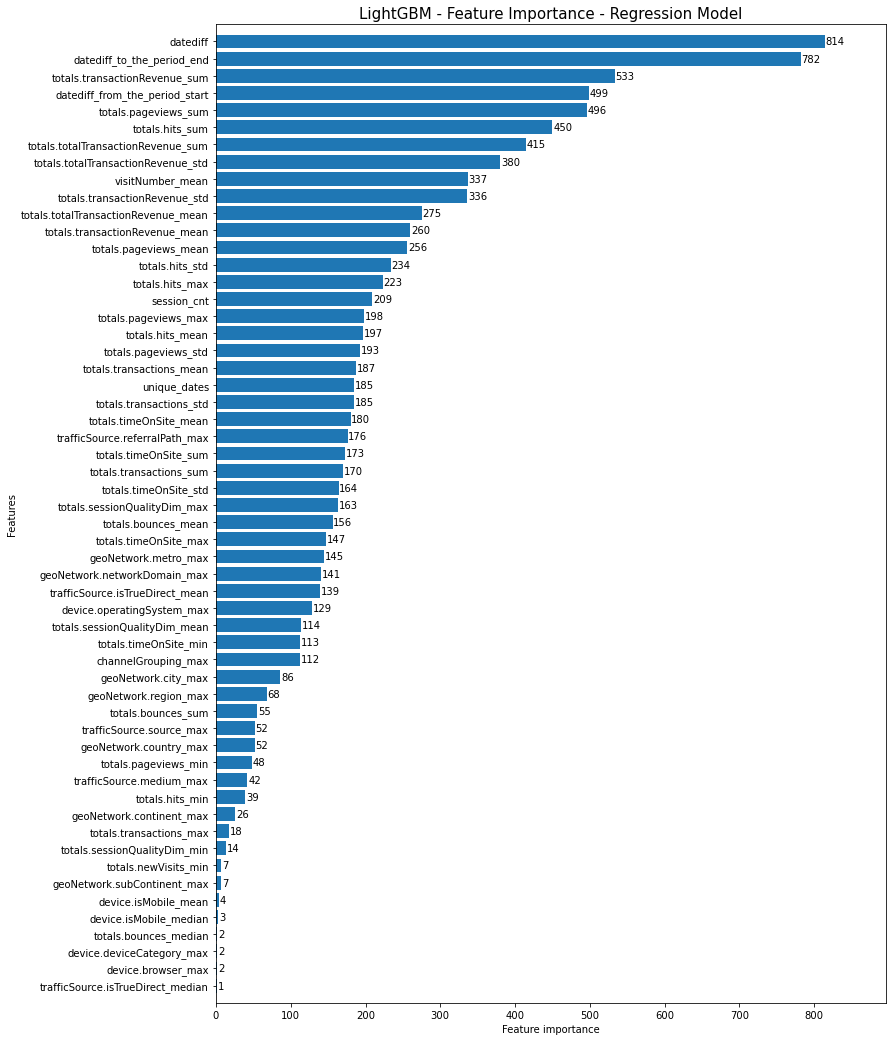

In [858]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model_reg, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance - Regression Model", fontsize=15)
plt.show()

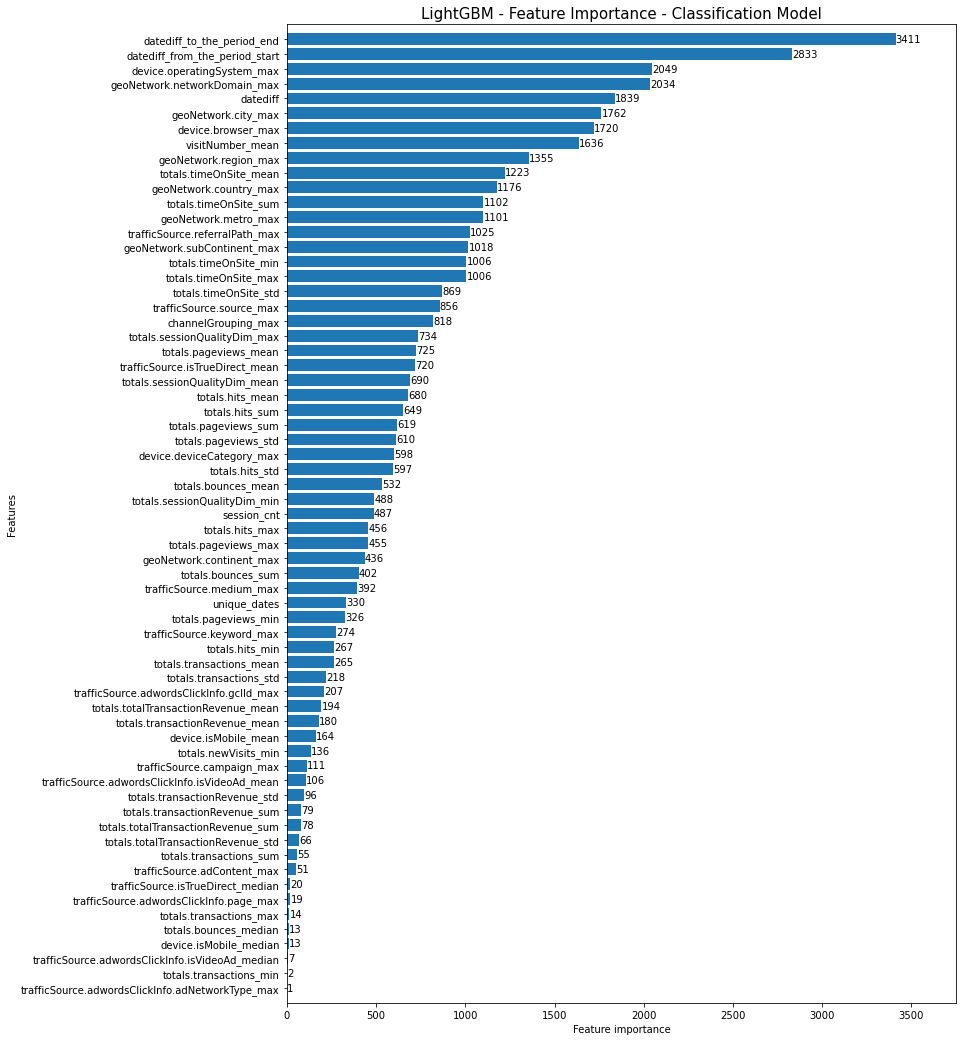

In [859]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgb_model_cl, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance - Classification Model", fontsize=15)
plt.show()

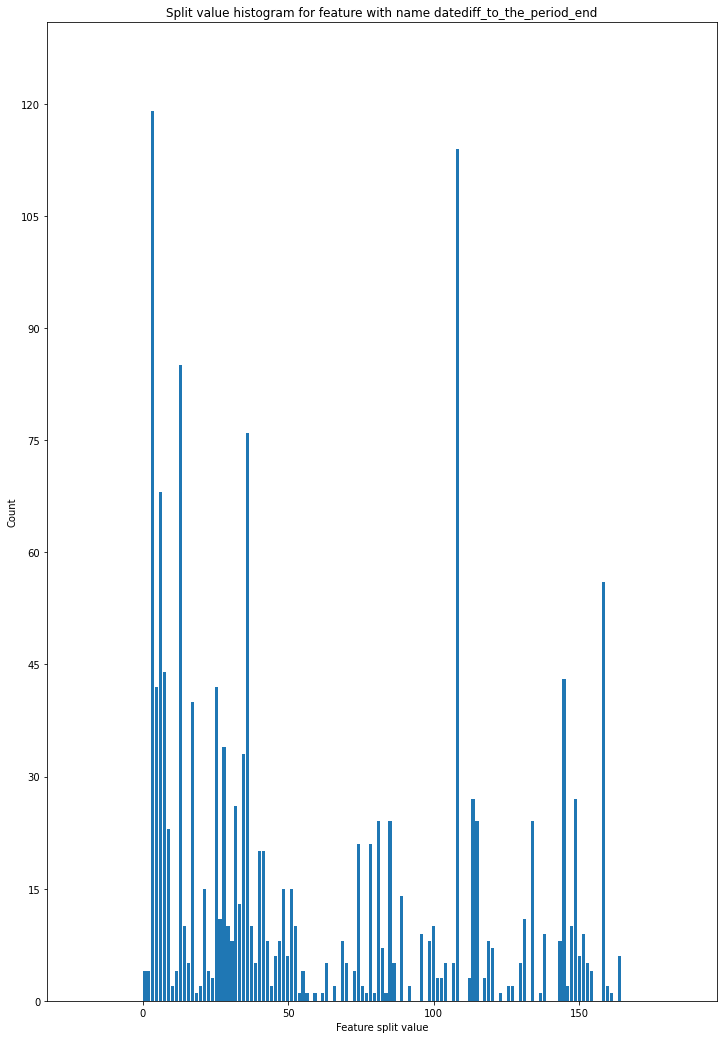

In [764]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_split_value_histogram(lgb_model_cl, 'datediff_to_the_period_end', ax=ax)
ax.grid(False)
plt.show()

In [905]:
pred_y_reg = lgb_model_reg.predict(val_X)
pred_y_reg[pred_y_reg < 0] = 0

In [906]:
pred_y_cl = lgb_model_cl.predict(val_X)

In [896]:
np.sqrt(mean_squared_error(val_y_reg, np.zeros(val_y.shape[0]))) # baseline prediction rmse (all-zero predictions)

0.30407420097899274

In [907]:
np.sqrt(mean_squared_error(val_y_reg, pred_y_reg*pred_y_cl))

0.30300640440387744

In [915]:
val_y[val_y==1].count()

1774

In [908]:
pd.Series(pred_y_cl).sort_values(ascending=False).head(1700)

171981    0.734370
143086    0.734024
216198    0.730058
70519     0.726957
270603    0.722030
            ...   
292008    0.152058
90901     0.152055
99671     0.152023
320161    0.151974
252347    0.151885
Length: 1700, dtype: float64

In [909]:
for idx in range(len(pred_y_cl)):
    pred_y_cl[idx] = 0 if pred_y[idx]<0.15 else 1
fpr_rf, tpr_rf, thresh = metrics.roc_curve(val_y, pred_y_cl)

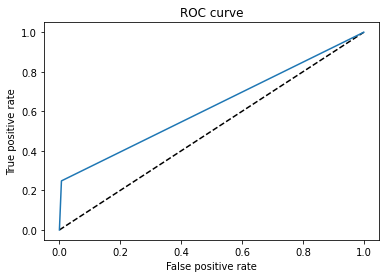

In [910]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [911]:
metrics.confusion_matrix(val_y, pred_y_cl)

array([[350275,   2346],
       [  1334,    440]])

In [912]:
print('auc score: ', metrics.auc(fpr_rf, tpr_rf))
print('f1 score: ', metrics.f1_score(val_y, pred_y))
print('accuracy: ', metrics.accuracy_score(val_y, pred_y))
print('precision: ', metrics.precision_score(val_y, pred_y))
print('recall: ', metrics.recall_score(val_y, pred_y))

auc score:  0.6206870110426118
f1 score:  0.19298245614035087
accuracy:  0.9896161063220418
precision:  0.15793251974156497
recall:  0.2480270574971815


In [913]:
# predict on test set

pred_test_reg = lgb_model_reg.predict(test_X)
pred_test_reg[pred_test_reg<0] = 0
pred_test_cl = lgb_model_cl.predict(test_X)
pred_test = pred_test_reg*pred_test_cl

result = pd.DataFrame()
result['fullVisitorId'] = test_id
result['PredictedLogRevenue'] = pred_test
result

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,1.098768e-05
1,0000039738481224681,1.279392e-06
2,0000073585230191399,1.272903e-06
3,0000087588448856385,2.945228e-07
4,0000149787903119437,3.543880e-07
...,...,...
296525,9999862054614696520,4.649107e-07
296526,9999898168621645223,1.227624e-06
296527,999990167740728398,1.413730e-06
296528,9999915620249883537,2.683756e-06


In [914]:
result.to_csv('result.csv', index=False)

In [919]:
result[result.PredictedLogRevenue>0]

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,1.098768e-05
1,0000039738481224681,1.279392e-06
2,0000073585230191399,1.272903e-06
3,0000087588448856385,2.945228e-07
4,0000149787903119437,3.543880e-07
...,...,...
296525,9999862054614696520,4.649107e-07
296526,9999898168621645223,1.227624e-06
296527,999990167740728398,1.413730e-06
296528,9999915620249883537,2.683756e-06


In [920]:
result.shape[0]

296530

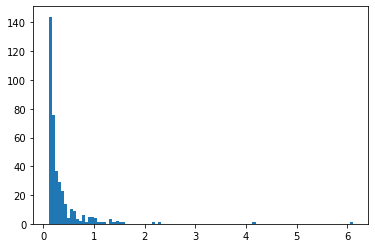

In [926]:
plt.hist(result[result.PredictedLogRevenue>0.1]['PredictedLogRevenue'], bins=100)
plt.show()

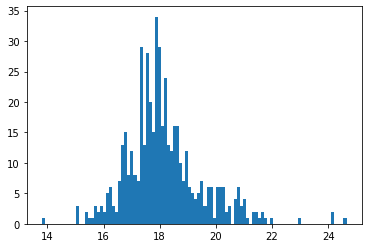

In [930]:
plt.hist(df_train[df_train.target>0.1]['target'], bins=100)
plt.show()